<a href="https://colab.research.google.com/github/SEC-API-io/sec-api-cookbook/blob/main/notebooks/sec-aaers/sec-aaers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Accounting and Auditing Enforcement Release 

This guide provides a comprehensive analysis of the Accounting and Auditing Enforcement Releases (AAERs) issued by the U.S. Securities and Exchange Commission (SEC). The analysis spans from the year 1997 to 2025 and covers various aspects of AAERs, including the frequency of releases, the types of violations, and the penalties imposed.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import json

style.use("default")

params = {
    "axes.labelsize": 8, "font.size": 8, "legend.fontsize": 8,
    "xtick.labelsize": 8, "ytick.labelsize": 8, "font.family": "sans-serif",
    "axes.spines.top": False, "axes.spines.right": False, "grid.color": "grey",
    "axes.grid": True, "axes.grid.axis": "y", "grid.alpha": 0.5, "grid.linestyle": ":",
}

plt.rcParams.update(params)

## Data Loading

The data is fetched using the `sec-api` library, which provides access to the SEC's AAER data via the [AAER Database API](https://sec-api.io/docs/aaer-database-api). The data is then processed and structured into a pandas DataFrame for further analysis. Various attributes of the AAERs, such as the date of release, the types of violations, and the penalties imposed, are extracted and transformed for analysis.


In [ ]:
!pip install sec-api

In [ ]:
from sec_api import AaerApi

aaerApi = AaerApi("YOUR_API_KEY")

YEARS = range(2025, 1996, -1)  # from 2025 to 1997
TARGET_FILE = "./data/aaer-structured-data.jsonl"

if not os.path.exists(TARGET_FILE):
    for year in YEARS:
        done = False
        search_from = 0
        year_counter = 0

        # fetch all AAERs for the given year
        while not done:
            searchRequest = {
                "query": f"dateTime:[{year}-01-01 TO {year}-12-31]",
                "from": search_from,
                "size": "50",
                "sort": [{"dateTime": {"order": "desc"}}],
            }

            response = aaerApi.get_data(searchRequest)

            if len(response["data"]) == 0:
                break

            search_from += 50
            year_counter += len(response["data"])

            with open(TARGET_FILE, "a") as f:
                for entry in response["data"]:
                    f.write(json.dumps(entry) + "\n")

        print(f"Finished loading {year_counter} AAERs for year {year}")
else:
    print("File already exists, skipping download")

Finished loading 8 AAERs for year 2025
Finished loading 65 AAERs for year 2024
Finished loading 111 AAERs for year 2023
Finished loading 86 AAERs for year 2022
Finished loading 77 AAERs for year 2021
Finished loading 88 AAERs for year 2020
Finished loading 97 AAERs for year 2019
Finished loading 95 AAERs for year 2018
Finished loading 75 AAERs for year 2017
Finished loading 108 AAERs for year 2016
Finished loading 111 AAERs for year 2015
Finished loading 92 AAERs for year 2014
Finished loading 87 AAERs for year 2013
Finished loading 85 AAERs for year 2012
Finished loading 127 AAERs for year 2011
Finished loading 131 AAERs for year 2010
Finished loading 179 AAERs for year 2009
Finished loading 149 AAERs for year 2008
Finished loading 228 AAERs for year 2007
Finished loading 170 AAERs for year 2006
Finished loading 194 AAERs for year 2005
Finished loading 213 AAERs for year 2004
Finished loading 219 AAERs for year 2003
Finished loading 208 AAERs for year 2002
Finished loading 121 AAERs f

In [4]:
aaers = pd.read_json(TARGET_FILE, lines=True)

# convert data types
bool_cols = ["hasAgreedToSettlement", "hasAgreedToPayPenalty"]
aaers[bool_cols] = aaers[bool_cols].astype(bool)
aaers["dateTime"] = pd.to_datetime(aaers["dateTime"], utc=True)
aaers["dateTime"] = aaers["dateTime"].dt.tz_convert("US/Eastern")
aaers["dateTimeYear"] = aaers["dateTime"].dt.year
aaers["dateTimeMonth"] = aaers["dateTime"].dt.month
aaers["dateTimeYearMonth"] = aaers["dateTime"].dt.to_period("M")
# Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday
aaers["dateTimeDay"] = aaers["dateTime"].dt.day_name()
# dateTimeClass: preMarket (4:00 AM to 9:30 AM), regularMarket (9:30 AM to 4:00 PM), afterMarket (4:00 PM to 8:00 PM), postMarket (8:00 PM to 10:00 PM)
aaers["dateTimeClass"] = aaers["dateTime"].apply(
    lambda x: (
        "preMarket"
        if x.hour < 9 or (x.hour == 9 and x.minute < 30)
        else (
            "regularMarket"
            if x.hour < 16
            else "afterMarket" if x.hour < 20 else "postMarket"
        )
    )
)

print(f"Loaded {len(aaers)} AAERs in total for {YEARS[-1]} to {YEARS[0]}")
print(aaers.info())

Loaded 3293 AAERs in total for 1997 to 2025
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3293 entries, 0 to 3292
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype                     
---  ------                  --------------  -----                     
 0   id                      3293 non-null   object                    
 1   dateTime                3293 non-null   datetime64[ns, US/Eastern]
 2   aaerNo                  3293 non-null   object                    
 3   releaseNo               3293 non-null   object                    
 4   respondents             3293 non-null   object                    
 5   respondentsText         3293 non-null   object                    
 6   urls                    3293 non-null   object                    
 7   summary                 3272 non-null   object                    
 8   tags                    3272 non-null   object                    
 9   entities                3272 non-null   object      

/var/folders/q3/bt7922t52p78qdm75h_8m5yh0000gn/T/ipykernel_81069/795053953.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  aaers["dateTimeYearMonth"] = aaers["dateTime"].dt.to_period("M")


In [5]:
aaers.head()

,id,dateTime,aaerNo,releaseNo,respondents,respondentsText,urls,summary,tags,entities,...,hasAgreedToPayPenalty,penaltyAmounts,requestedRelief,violatedSections,otherAgenciesInvolved,dateTimeYear,dateTimeMonth,dateTimeYearMonth,dateTimeDay,dateTimeClass
0,a1713f9f48aa9129833f02e76cc6eeed,2025-02-04 10:00:21-05:00,AAER-4562,"[33-11364, 34-102332]","[{'name': 'Karen J. Smith, CPA', 'type': 'indi...","Karen J. Smith, CPA","[{'type': 'primary', 'url': 'https://www.sec.g...",The SEC has instituted public administrative p...,"[accounting fraud, disclosure fraud]","[{'name': 'Karen J. Smith', 'type': 'individua...",...,True,"[{'penaltyAmount': '43348.59', 'penaltyAmountT...","[disgorgement of profits, civil penalties, per...",[Sections 17(a)(2) and (3) of the Securities A...,[],2025,2,2025-02,Tuesday,regularMarket
1,044e225c5b8cc62902c5cba3928b1840,2025-01-29 12:56:13-05:00,AAER-4561,"[33-11363, 34-102306]","[{'name': 'Jason M. Boucher, CPA', 'type': 'in...","Jason M. Boucher, CPA","[{'type': 'primary', 'url': 'https://www.sec.g...",The SEC has instituted public administrative p...,"[accounting fraud, disclosure fraud]","[{'name': 'Jason M. Boucher', 'type': 'individ...",...,True,"[{'penaltyAmount': '20102', 'penaltyAmountText...","[disgorgement of profits, civil penalties, per...",[Sections 17(a)(2) and (3) of the Securities A...,[],2025,1,2025-01,Wednesday,regularMarket
2,09a3b5479d46cf2be7a1e7368c107182,2025-01-17 09:49:03-05:00,AAER-4556,[33-11354],"[{'name': 'GrubMarket, Inc.', 'type': 'company'}]","GrubMarket, Inc.","[{'type': 'primary', 'url': 'https://www.sec.g...",The SEC has instituted cease-and-desist procee...,[disclosure fraud],"[{'name': 'GrubMarket, Inc.', 'type': 'company...",...,True,"[{'penaltyAmount': '8000000', 'penaltyAmountTe...","[cease and desist order, civil penalties]",[Sections 17(a)(2) and 17(a)(3) of the Securit...,[],2025,1,2025-01,Friday,regularMarket
3,8e91cb6a1df4a724aedcff7d6ed21c37,2025-01-17 09:21:59-05:00,AAER-4560,"[34-102231, IA-6828]","[{'name': 'Jeffery Q. Johnson, CPA', 'type': '...","Jeffery Q. Johnson, CPA","[{'type': 'primary', 'url': 'https://www.sec.g...",The SEC has instituted proceedings against Jef...,"[auditor independence, improper professional c...","[{'name': 'Jeffery Q. Johnson', 'type': 'indiv...",...,True,"[{'penaltyAmount': '30000', 'penaltyAmountText...","[cease and desist order, civil penalties]","[Section 206(4) of the Advisers Act, Rule 206(...",[],2025,1,2025-01,Friday,preMarket
4,e9f5e13f8812a0cf9bc8ee69c132b8d9,2025-01-17 08:47:55-05:00,AAER-4559,[34-102227],"[{'name': 'Celsius Holdings, Inc.', 'type': 'c...","Celsius Holdings, Inc.","[{'type': 'primary', 'url': 'https://www.sec.g...",The SEC has instituted cease-and-desist procee...,"[disclosure fraud, accounting violations]","[{'name': 'Celsius Holdings, Inc.', 'type': 'c...",...,True,"[{'penaltyAmount': '3000000', 'penaltyAmountTe...",[cease and desist from committing or causing a...,"[Sections 13(a), 13(b)(2)(A), and 13(b)(2)(B) ...",[],2025,1,2025-01,Friday,preMarket


## AAER Releases by Year, Month, Day of Week and Time of Day


In [6]:
df_year_month = aaers.pivot_table(
    index="dateTimeYear",
    columns="dateTimeMonth",
    values="id",
    aggfunc="count",
    fill_value=0,
)
df_year_month_pretty = df_year_month.copy()
# convert col 1 to 12 to month names, eg 1 => Jan, 2 => Feb, etc
df_year_month_pretty.columns = df_year_month_pretty.columns.map(
    lambda x: pd.to_datetime(str(x), format="%m").strftime("%b")
)

total_col = df_year_month_pretty.sum(axis=1)
mean_col = round(df_year_month_pretty.mean(axis=1), 0)
median_col = round(df_year_month_pretty.median(axis=1), 0)

df_year_month_pretty["total"] = total_col
df_year_month_pretty["mean"] = mean_col
df_year_month_pretty["median"] = median_col

total_row = df_year_month_pretty.sum(axis=0)
mean_row = round(df_year_month_pretty.mean(axis=0), 0)
median_row = round(df_year_month_pretty.median(axis=0), 0)

df_year_month_pretty.loc["total"] = total_row
df_year_month_pretty.loc["mean"] = mean_row
df_year_month_pretty.loc["median"] = median_row

df_year_month_pretty = df_year_month_pretty.astype(int)

print("Accounting and Auditing Enforcement Releases by Year and Month")
df_year_month_pretty

Accounting and Auditing Enforcement Releases by Year and Month


dateTimeMonth,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,total,mean,median
dateTimeYear,,,,,,,,,,,,,,,
1997,0,0,0,0,0,0,0,0,0,0,1,4,5,0,0
1999,0,0,0,0,0,0,0,0,0,8,11,3,22,2,0
2000,5,15,12,6,11,20,6,8,30,11,9,9,142,12,10
2001,6,8,7,6,13,15,13,5,27,12,1,8,121,10,8
2002,18,6,30,12,12,24,16,17,14,19,22,18,208,17,18
2003,10,16,20,19,21,16,18,19,30,24,10,16,219,18,18
2004,11,16,16,15,26,23,21,22,24,11,18,10,213,18,17
2005,18,14,28,17,10,20,14,21,23,11,8,10,194,16,16
2006,10,20,18,18,10,21,15,8,11,15,12,12,170,14,14


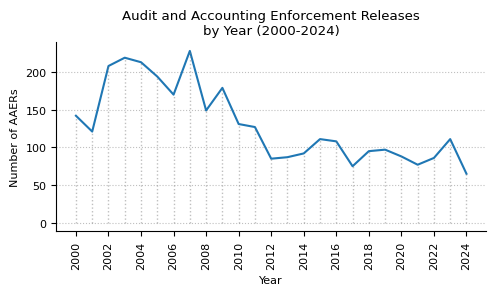

In [7]:
fig, ax = plt.subplots(figsize=(5, 3))

data_to_plot = df_year_month_pretty.loc[2000:2024].copy()
data_to_plot.index = data_to_plot.index.astype(int)
data_to_plot["total"].plot(kind="line", ax=ax)

ax.set_title("Audit and Accounting Enforcement Releases\nby Year (2000-2024)")
ax.set_xlabel("Year")
ax.set_ylabel("Number of AAERs")
ax.set_axisbelow(True)
ax.set_xticks(data_to_plot.index[::2])
plt.xticks(rotation=90)

for year in data_to_plot.index:
    year_y_max = data_to_plot.loc[year, "total"]
    ax.vlines(year, 0, year_y_max, linestyles=":", colors="grey", alpha=0.5, lw=1)

plt.grid(axis="x")
plt.tight_layout()
plt.show()

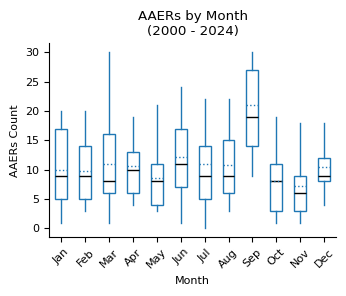

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 3))

df_year_month.loc[2000:2024].boxplot(
    ax=ax,
    grid=False,
    showfliers=False,
    flierprops=dict(marker="o", markersize=3),
    patch_artist=True,
    boxprops=dict(facecolor="white", color="tab:blue"),
    showmeans=True,
    meanline=True,
    meanprops={"color": "tab:blue", "linestyle": ":"},
    medianprops={"color": "black"},
    capprops={"color": "none"},
)

ax.set_title("AAERs by Month\n(2000 - 2024)")
ax.set_xlabel("Month")
ax.set_ylabel("AAERs Count")
xticklabels = [pd.to_datetime(str(x), format="%m").strftime("%b") for x in range(1, 13)]
ax.set_xticklabels(xticklabels)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
counts_dayOfWeek = (
    aaers[aaers["dateTimeYear"].between(2000, 2024)]
    .groupby(["dateTimeDay"])
    .size()
    .to_frame(name="Count")
).rename_axis("Day of the Week")
counts_dayOfWeek["Pct"] = (
    counts_dayOfWeek["Count"].astype(int) / counts_dayOfWeek["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_dayOfWeek["Count"] = counts_dayOfWeek["Count"].map(lambda x: f"{x:,}")

print(f"AAER disclosures by day of the week (2000 - 2024).")
counts_dayOfWeek.loc[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]]

AAER disclosures by day of the week (2000 - 2024).


,Count,Pct
Day of the Week,,
Monday,574,18%
Tuesday,643,20%
Wednesday,716,22%
Thursday,765,23%
Friday,559,17%


In [10]:
counts_filedAtClass = (
    aaers[aaers["dateTimeYear"].between(2000, 2024)]
    .groupby(["dateTimeClass"])
    .size()
    .sort_values(ascending=False)
    .to_frame(name="Count")
).rename_axis("Publication Time")
counts_filedAtClass["Pct"] = (
    counts_filedAtClass["Count"].astype(int)
    / counts_filedAtClass["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_filedAtClass["Count"] = counts_filedAtClass["Count"].map(lambda x: f"{x:,}")
counts_filedAtClass = counts_filedAtClass.reindex(
    ["preMarket", "regularMarket", "afterMarket"]
)
counts_filedAtClass.index = (
    counts_filedAtClass.index.str.replace("preMarket", "Pre-Market (4:00 - 9:30 AM)")
    .str.replace("regularMarket", "Market Hours (9:30 AM - 4:00 PM)")
    .str.replace("afterMarket", "After Market (4:00 - 8:00 PM)")
)

print(
    f"AAER disclosures by pre-market, regular market hours,\nand after-market publication time (2000 - 2024)."
)
counts_filedAtClass

AAER disclosures by pre-market, regular market hours,
and after-market publication time (2000 - 2024).


,Count,Pct
Publication Time,,
Pre-Market (4:00 - 9:30 AM),"2,389",73%
Market Hours (9:30 AM - 4:00 PM),824,25%
After Market (4:00 - 8:00 PM),45,1%


## Penalty Amounts over Time


In [11]:
counts_hasAgreedToPayPenalty = (
    aaers[aaers["dateTimeYear"].between(2000, 2024)]
    .groupby(["hasAgreedToPayPenalty"])
    .size()
    .to_frame(name="Count")
).rename_axis("Has Agreed to Pay Penalty")
counts_hasAgreedToPayPenalty["Pct"] = (
    counts_hasAgreedToPayPenalty["Count"].astype(int)
    / counts_hasAgreedToPayPenalty["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_hasAgreedToPayPenalty["Count"] = counts_hasAgreedToPayPenalty["Count"].map(
    lambda x: f"{x:,}"
)

print(
    f"AAER disclosures by whether the company has agreed to pay a penalty (2000 - 2024)."
)
counts_hasAgreedToPayPenalty

AAER disclosures by whether the company has agreed to pay a penalty (2000 - 2024).


,Count,Pct
Has Agreed to Pay Penalty,,
False,"1,612",49%
True,"1,646",51%


In [12]:
penality_amounts = aaers.explode("penaltyAmounts").copy()
penality_amounts["penaltyAmount"] = penality_amounts["penaltyAmounts"].apply(
    lambda x: x["penaltyAmount"] if isinstance(x, dict) else np.nan
)
penality_amounts["penaltyAmount"] = penality_amounts["penaltyAmount"].astype(float)
penality_amounts["penaltyAmount"] = penality_amounts["penaltyAmount"] / 1000
penality_amounts["penaltyAmount"].describe().apply(lambda x: f"{x:,.0f}").to_frame()

,penaltyAmount
count,"3,102"
mean,"8,320"
std,"74,308"
min,0
25%,30
50%,85
75%,500
max,"2,250,000"


In [13]:
penalties_year = penality_amounts.groupby("dateTimeYear")["penaltyAmount"].sum()
penalties_year = penalties_year.astype(int)
penalties_year = pd.DataFrame(penalties_year)
penalties_year["penaltyAmount"] = round(penalties_year["penaltyAmount"] / 1_000, 2)
print("Total Penalties in Million USD by Year")
penalties_year.map(lambda x: f"{x:,.1f}")

Total Penalties in Million USD by Year


,penaltyAmount
dateTimeYear,
1997,0.0
1999,0.3
2000,26.8
2001,12.4
2002,246.6
2003,"8,731.7"
2004,"1,618.5"
2005,"2,041.2"
2006,"1,445.7"


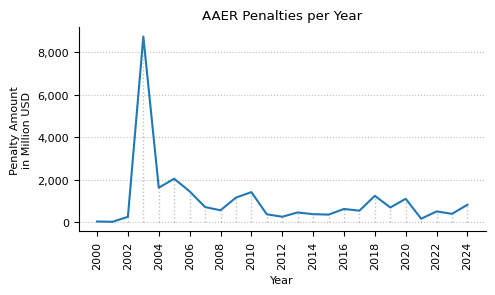

In [14]:
fig, ax = plt.subplots(figsize=(5, 3))

data_to_plot = penalties_year.loc[2000:2024].copy()
data_to_plot["penaltyAmount"].plot(kind="line", ax=ax)

for year in data_to_plot.index:
    year_y_max = data_to_plot.loc[year, "penaltyAmount"]
    ax.vlines(year, 0, year_y_max, linestyles=":", colors="grey", alpha=0.5, lw=1)

ax.set_xticks(data_to_plot.index[::2])
plt.xticks(rotation=90)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set_title("AAER Penalties per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Penalty Amount\nin Million USD")
plt.tight_layout()
plt.grid(axis="x")
ax.set_axisbelow(True)
plt.show()

## AAERs by Type

In [15]:
all_tags = []

for i, row in aaers.iterrows():
    tags = row["tags"]
    if isinstance(tags, list):
      all_tags.extend(tags)

all_tags = pd.Series(all_tags)
all_tags = all_tags.value_counts().reset_index()
all_tags.columns = ["tag", "count"]

print("Top 10 Tags in AAER Releases from 1997 to 2025")
all_tags.head(10)

Top 10 Tags in AAER Releases from 1997 to 2025


,tag,count
0,disclosure fraud,1648
1,accounting fraud,1092
2,securities fraud,404
3,improper professional conduct,254
4,financial fraud,229
5,accounting violations,161
6,fraud,150
7,insider trading,144
8,reinstatement,127
9,securities violation,125


## Violated Securities Laws

In [16]:
# count all unique violatedSections
all_violated_sections = []

for i, row in aaers.iterrows():
    violatedSections = row["violatedSections"]
    if isinstance(violatedSections, list):
        all_violated_sections.extend(violatedSections)

all_violated_sections = pd.Series(all_violated_sections)
all_violated_sections = all_violated_sections.value_counts().reset_index()

all_violated_sections.columns = ["violatedSections", "count"]

print("Top 10 Violated Securities Laws in SEC Litigation Releases")
all_violated_sections.head(10)

Top 10 Violated Securities Laws in SEC Litigation Releases


,violatedSections,count
0,Section 17(a) of the Securities Act of 1933,657
1,Rule 10b-5,447
2,Section 13(a) of the Exchange Act,399
3,Section 10(b) of the Securities Exchange Act o...,299
4,"Sections 13(a), 13(b)(2)(A) and 13(b)(2)(B) of...",296
5,Sections 10(b) and 13(b)(5) of the Securities ...,268
6,"Sections 13(a), 13(b)(2)(A), and 13(b)(2)(B) o...",247
7,Section 10(b) of the Exchange Act,245
8,Section 13(b)(5) of the Exchange Act,243
9,Sections 10(b) and 13(b)(5) of the Exchange Act,222
